# Expectation Propagation

ForneyLab comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit function links continuous variable `x_t` with the discrete variable `y_t`. The model is defined as:

\begin{align*}
    u &= 0.1\\
    x_0 &\sim \mathcal{N}(0, 100)\\
    x_t &\sim \mathcal{N}(x_{t-1} + u, 0.01)\\
    y_t &\sim \mathcal{B}er(\Phi(x_t))
\end{align*}

The FFG representation of this model consists of a concatenation of the following sections (one per timestep):

```
              (u)   (0.01)
               |      |
               v      v
(x_t_min) ---> + --->[N]---> = ---> (x_t)
                             |
                            [Φ]
                             | 
                           (y_t)
```

In [49]:
using SpecialFunctions
using StatsFuns
using Random

# Generate data set

# Generate data set
Random.seed!(123)
n_samples = 40

u_data = 0.1
x_data = []
y_data = []
x_prev = -2.0
for t=1:n_samples
    push!(x_data, x_prev + u_data + sqrt(0.01)*randn()) # State transition
    push!(y_data, normcdf(x_data[end]) > rand()); # Observation
    x_prev = x_data[end]
end

# Model specification

In [50]:
using ForneyLab

g = FactorGraph()

# State prior
@RV x_0 ~ Gaussian(0.0, 100.0)

x = Vector{Variable}(undef, n_samples)
d = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)
x_t_min = x_0
for t = 1:n_samples
    @RV d[t] ~ Gaussian(u_data, 0.01)
    @RV x[t] = x_t_min + d[t]
    @RV y[t] ~ Probit(x[t])

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Algorithm generation

With the model defined, we can now generate an EP algorithm. The EP algorithm requires initial messages. To automatically populate the messages array with inital messages, an `init()` function is generated. The EP algorithm is executed by calling `init()` once, and then calling `step!(...)` repeatedly until convergence.

In [51]:
ep_sites = [(:probit_*t, :in1) for t=1:n_samples]
algo = messagePassingAlgorithm(x, ep_sites=ep_sites)
source_code = algorithmSourceCode(algo)
# println(source_code) # Uncomment to inspect algorithm code
;

# Execution

In [52]:
eval(Meta.parse(source_code));

In [53]:
messages = init()
marginals = Dict()
data = Dict(:y => y_data)

n_its = 4*n_samples
for i = 1:n_its
   step!(data, marginals, messages)
end

# Results

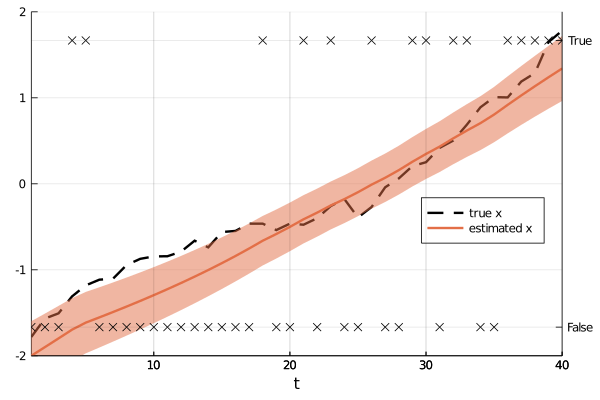

In [54]:
using Plots

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples]

plot(1:n_samples, x_data, 
     linestyle=:dash, 
     color=:black, 
     linewidth=2, 
     label="true x",
     xlabel="t",
     ylim=(-2, 2), 
     xlim=(1, n_samples),
     legend=:right)
plot!(1:n_samples, m_x, 
      ribbon=(sqrt.(v_x), sqrt.(v_x)), 
      linewidth=2, 
      label="estimated x")
p2 = Plots.twinx()
scatter!(p2, 1:n_samples, y_data,
         label=false,
         yticks=([0.0, 1.0], ["False", "True"]),
         color=:black,
         xlim=(1, n_samples),
         marker=:x,
         ylim=(-0.1, 1.1))